# Chapter 10 - Introduction to Artificial Neural Networks with Keras
- Inspiration in nature
- Biological neurons -> Artificial neurons

## Contents
- Getting to the Multi-Layer Perceptron (MLP)
- Building a MLP using Keras

### From biological neurons to artificial neurons

- Neural networks are old
    - "A logical calculus of ideas immanent in nervous activity" - McCulloch and Pitts (1943)
- Interest in it came and went over the decades
- It might be the case that now it is here to stay
    - Quantity of data available
    - Computing power increase
    - Better training algorithms
    - Local optima is not that bad in practice
    - Funding has resulted in progress lately
    
#### Biological neurons

- A single neuron

<img src="Imagens/bioneuron.png">

- Layers of neurons

<img src="Imagens/biolayer.png">

#### Logical computation with neurons

- Warren McCulloch and Walter Pitts Neuron, 1943.

<img src="Imagens/artneuron.png">

- Perceptron, Frank Rosenblatt, 1957.

<img src="Imagens/perceptron.png">

<img src="Imagens/perceptron2.png">

<img src="Imagens/perceptron3.png">

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)] # petal length, petal width
y = (iris.target == 0).astype(np.int) # Iris Setosa?
per_clf = Perceptron()
per_clf.fit(X, y)
y_pred = per_clf.predict([[2, 0.5]])

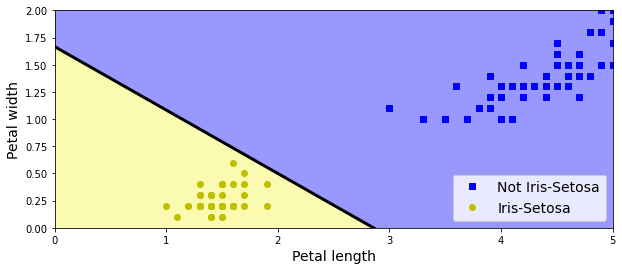

In [2]:
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0, 5, 0, 2]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

plt.show()

- Marvin Minsky and Seymour Papert, 1969.
    - Highlighted perceptron weaknesses
    - Can't learn XOR
    - This weakness can be removed by stacking multiple perceptrons.
    
<img src="Imagens/xor.png">

#### Multi-layer perceptron and back propagation

- 3b1b - Neural network playlist

[![](http://img.youtube.com/vi/aircAruvnKk/0.jpg)](http://www.youtube.com/watch?v=aircAruvnKk "3b1b - Neural network playlist")

- Welch Labs - Neural network playlist

[![](http://img.youtube.com/vi/bxe2T-V8XRs/0.jpg)](http://www.youtube.com/watch?v=bxe2T-V8XRs "Welch Labs - Neural network playlist")

### Multi-layer perceptron schema

<img src="Imagens/mlp.png">

- Many layers stacked on top of each other (Deep)
- Decades trying to find a way to train them, very little success
- Backpropagation training algorithm, David Rumelhart, Geoffrey Hinton and Ronald Williams, 1986.
    - Gradient descent with efficient technique to automatically compute gradients

- Backpropagation algorithm
    - Handles one mini-batch at a time
    - A pass through all instance is called an epoch
    - foward pass (intermediate results are cached)
    - measure output error
    - computes the contributio of each connection to the error through chain rule
    - updates the weights
- Activation functions
    - Sigmoid (Rumelhart paper's choice)
    - Hyperbolic tangent
    - Rectified linear unit
    - Softplus
    - ...
    
<img src="Imagens/activ.png">

#### Regression MLPs
- Output activation: ReLu/Softplus (positive outputs), logistic/tanh (bounded outputs)
- Loss: MSE or MAE/Huber (if there are outliers)

#### Classification MLPs
- Output activation: Logistic (binary), Softmax(multiclass)
- Loss: MSE or MAE/Huber (if there are outliers)

### Implementing MLP's with Keras
- Sequential API
    - Classification
    - Regression
- Functional API

### Sequential API

#### Building an Image Classifier using the sequential API

In [3]:
import tensorflow as tf
from tensorflow import keras

#### Loading data with keras.datasets

In [4]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

- 60000 28X28 grayscale images

In [5]:
X_train_full.shape

(60000, 28, 28)

#### Creating a validation set

In [6]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

- What an example looks like?

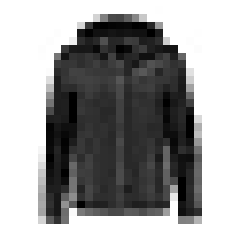

In [7]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

In [8]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

In [9]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [10]:
class_names[y_train[0]]

'Coat'

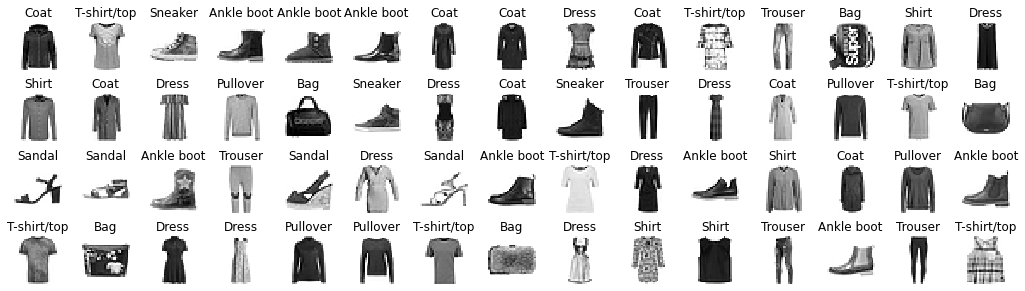

In [11]:
n_rows = 4
n_cols = 15
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

#### Creating the model with the sequential API #1

In [12]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


#### Creating the model with the sequential API #2

In [14]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


#### List the layers

In [16]:
model.layers

In [17]:
hidden1 = model.layers[1]

In [18]:
weights, biases = hidden1.get_weights()

In [19]:
weights

array([[-6.4410530e-02,  4.4310823e-02, -5.0729871e-02, ...,
        -1.4930379e-02, -2.1941494e-02, -1.3807483e-02],
       [-2.1084171e-02,  6.9389790e-03, -6.8886958e-02, ...,
        -5.2052140e-02, -5.1032159e-02,  3.6087312e-02],
       [-5.5392340e-02, -6.7793064e-02, -5.4584645e-02, ...,
        -6.9570169e-02, -6.9586635e-03,  1.9336529e-02],
       ...,
       [ 3.8992167e-02,  9.1865659e-06,  7.1894646e-02, ...,
        -6.8635754e-02,  5.4154873e-02,  5.4808423e-02],
       [-3.9843600e-02, -3.0470353e-02,  3.7246227e-02, ...,
         1.3626590e-02, -1.5415225e-02, -2.1660440e-02],
       [-6.4390607e-02, -1.4924079e-02, -1.4129069e-02, ...,
         2.2175938e-02,  1.4035873e-02, -6.5941818e-02]], dtype=float32)

In [20]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

#### Compiling the model

In [21]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

#### Fitting the model

In [22]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 11s 7ms/step - loss: 0.7235 - accuracy: 0.7644 - val_loss: 0.5335 - val_accuracy: 0.8180
Epoch 2/30
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4942 - accuracy: 0.8273 - val_loss: 0.4863 - val_accuracy: 0.8264
Epoch 3/30
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4486 - accuracy: 0.8438 - val_loss: 0.4227 - val_accuracy: 0.8518
Epoch 4/30
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4228 - accuracy: 0.8520 - val_loss: 0.4272 - val_accuracy: 0.8510
Epoch 5/30
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4035 - accuracy: 0.8587 - val_loss: 0.3945 - val_accuracy: 0.8638
Epoch 6/30
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3869 - accuracy: 0.8645 - val_loss: 0.4028 - val_accuracy: 0.8562
Epoch 7/30
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3731 - accuracy: 0.8685 - val_loss: 0.3611 - val_accurac

In [23]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 1719}

In [24]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [25]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

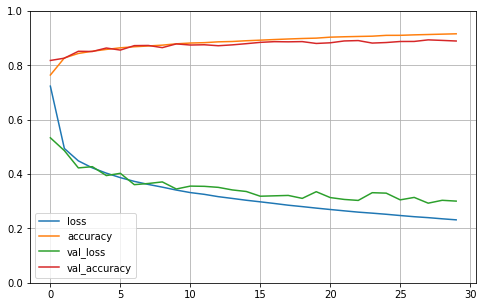

In [26]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [27]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 2s 6ms/step - loss: 0.3306 - accuracy: 0.8793


[0.33063945174217224, 0.8792999982833862]

In [28]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [29]:
y_pred = model.predict_classes(X_new)
y_pred

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([9, 2, 1], dtype=int64)

In [30]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [31]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

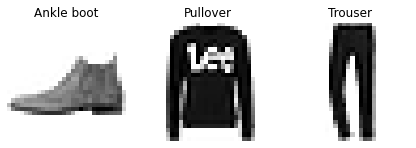

In [32]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

#### Building an Regression modelusing the sequential API

In [33]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [34]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 2s 6ms/step - loss: 2.0316 - val_loss: 1.4573
Epoch 2/20
363/363 [==============================] - 2s 5ms/step - loss: 0.8999 - val_loss: 0.7982
Epoch 3/20
363/363 [==============================] - 2s 5ms/step - loss: 0.7768 - val_loss: 0.7328
Epoch 4/20
363/363 [==============================] - 2s 5ms/step - loss: 0.7214 - val_loss: 0.7506
Epoch 5/20
363/363 [==============================] - 2s 5ms/step - loss: 0.6790 - val_loss: 0.7030
Epoch 6/20
363/363 [==============================] - 2s 5ms/step - loss: 0.6414 - val_loss: 0.6671
Epoch 7/20
363/363 [==============================] - 2s 5ms/step - loss: 0.6092 - val_loss: 0.5919
Epoch 8/20
363/363 [==============================] - 2s 5ms/step - loss: 0.5807 - val_loss: 0.5702
Epoch 9/20
363/363 [==============================] - 2s 5ms/step - loss: 0.5564 - val_loss: 0.5726
Epoch 10/20
363/363 [==============================] - 2s 5ms/step - loss: 0.5367 - val_loss: 0.5360

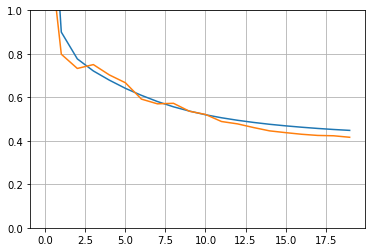

In [35]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [36]:
y_pred

array([[0.81849664],
       [1.6877646 ],
       [3.010167  ]], dtype=float32)

### Functional API

#### Building complex models using the Functional API

<img src="Imagens/widedeep.png">

In [37]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_], outputs=[output])

In [38]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 30)           270         input_1[0][0]                    
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 30)           930         dense_8[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 38)           0           input_1[0][0]                    
                                                                 dense_9[0][0]         

In [39]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 2s 6ms/step - loss: 1.5668 - val_loss: 0.8839
Epoch 2/20
363/363 [==============================] - 2s 5ms/step - loss: 0.7364 - val_loss: 0.6948
Epoch 3/20
363/363 [==============================] - 2s 5ms/step - loss: 0.6707 - val_loss: 0.6404
Epoch 4/20
363/363 [==============================] - 2s 5ms/step - loss: 0.6277 - val_loss: 0.5911
Epoch 5/20
363/363 [==============================] - 2s 5ms/step - loss: 0.5946 - val_loss: 0.5602
Epoch 6/20
363/363 [==============================] - 2s 5ms/step - loss: 0.5679 - val_loss: 0.5888
Epoch 7/20
363/363 [==============================] - 2s 5ms/step - loss: 0.5472 - val_loss: 0.5103
Epoch 8/20
363/363 [==============================] - 2s 5ms/step - loss: 0.5291 - val_loss: 0.5139
Epoch 9/20
363/363 [==============================] - 2s 5ms/step - loss: 0.5137 - val_loss: 0.5168
Epoch 10/20
363/363 [==============================] - 2s 5ms/step - loss: 0.5010 - val_loss: 0.4724

<img src="Imagens/manyinput.png">

In [40]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

In [41]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid))
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))

Epoch 1/20
363/363 [==============================] - 2s 6ms/step - loss: 2.3570 - val_loss: 1.7819
Epoch 2/20
363/363 [==============================] - 2s 5ms/step - loss: 0.7944 - val_loss: 0.6854
Epoch 3/20
363/363 [==============================] - 2s 5ms/step - loss: 0.6996 - val_loss: 0.6288
Epoch 4/20
363/363 [==============================] - 2s 5ms/step - loss: 0.6543 - val_loss: 0.5930
Epoch 5/20
363/363 [==============================] - 2s 5ms/step - loss: 0.6187 - val_loss: 0.5891
Epoch 6/20
363/363 [==============================] - 2s 5ms/step - loss: 0.5884 - val_loss: 0.5509
Epoch 7/20
363/363 [==============================] - 2s 6ms/step - loss: 0.5597 - val_loss: 0.5078
Epoch 8/20
363/363 [==============================] - 2s 6ms/step - loss: 0.5352 - val_loss: 0.5055
Epoch 9/20
363/363 [==============================] - 2s 6ms/step - loss: 0.5126 - val_loss: 0.4870
Epoch 10/20
363/363 [==============================] - 2s 5ms/step - loss: 0.4957 - val_loss: 0.6019

<img src="Imagens/manyinmanyout.png">

In [42]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)
model = keras.models.Model(inputs=[input_A, input_B],
                           outputs=[output, aux_output])

In [43]:
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(lr=1e-3))

In [44]:
history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=20,
                    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))

Epoch 1/20
363/363 [==============================] - 4s 10ms/step - loss: 2.1373 - main_output_loss: 1.9391 - aux_output_loss: 3.9211 - val_loss: 1.1017 - val_main_output_loss: 0.9004 - val_aux_output_loss: 2.9137
Epoch 2/20
363/363 [==============================] - 3s 9ms/step - loss: 0.9568 - main_output_loss: 0.7885 - aux_output_loss: 2.4718 - val_loss: 0.9150 - val_main_output_loss: 0.7255 - val_aux_output_loss: 2.6200
Epoch 3/20
363/363 [==============================] - 3s 9ms/step - loss: 0.8004 - main_output_loss: 0.6788 - aux_output_loss: 1.8947 - val_loss: 0.8389 - val_main_output_loss: 0.6339 - val_aux_output_loss: 2.6836
Epoch 4/20
363/363 [==============================] - 3s 10ms/step - loss: 0.7265 - main_output_loss: 0.6249 - aux_output_loss: 1.6410 - val_loss: 0.7918 - val_main_output_loss: 0.5876 - val_aux_output_loss: 2.6290
Epoch 5/20
363/363 [==============================] - 3s 9ms/step - loss: 0.6793 - main_output_loss: 0.5875 - aux_output_loss: 1.5061 - val_lo

### Subclassing API

In [45]:
class WideAndDeepModel(keras.models.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
        
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

model = WideAndDeepModel(30, activation="relu")

In [46]:
model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit((X_train_A, X_train_B), (y_train, y_train), epochs=10,
                    validation_data=((X_valid_A, X_valid_B), (y_valid, y_valid)))
total_loss, main_loss, aux_loss = model.evaluate((X_test_A, X_test_B), (y_test, y_test))
y_pred_main, y_pred_aux = model.predict((X_new_A, X_new_B))

Epoch 1/10
363/363 [==============================] - 4s 10ms/step - loss: 2.1203 - output_1_loss: 1.7842 - output_2_loss: 5.1452 - val_loss: 6.2788 - val_output_1_loss: 6.0315 - val_output_2_loss: 8.5039
Epoch 2/10
363/363 [==============================] - 3s 9ms/step - loss: 1.0294 - output_1_loss: 0.7800 - output_2_loss: 3.2742 - val_loss: 1.4334 - val_output_1_loss: 0.8452 - val_output_2_loss: 6.7274
Epoch 3/10
363/363 [==============================] - 4s 10ms/step - loss: 0.8144 - output_1_loss: 0.6547 - output_2_loss: 2.2515 - val_loss: 1.2452 - val_output_1_loss: 0.6167 - val_output_2_loss: 6.9017
Epoch 4/10
363/363 [==============================] - 3s 9ms/step - loss: 0.7186 - output_1_loss: 0.6024 - output_2_loss: 1.7646 - val_loss: 1.1912 - val_output_1_loss: 0.5550 - val_output_2_loss: 6.9167
Epoch 5/10
363/363 [==============================] - 3s 9ms/step - loss: 0.6611 - output_1_loss: 0.5646 - output_2_loss: 1.5298 - val_loss: 1.1200 - val_output_1_loss: 0.5166 - val_

### Saving and Restoring Models

In [47]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

In [48]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 2s 6ms/step - loss: 1.9017 - val_loss: 1.0421
Epoch 2/10
363/363 [==============================] - 2s 5ms/step - loss: 0.8238 - val_loss: 0.9994
Epoch 3/10
363/363 [==============================] - 2s 5ms/step - loss: 0.7430 - val_loss: 0.8083
Epoch 4/10
363/363 [==============================] - 2s 5ms/step - loss: 0.6815 - val_loss: 0.9570
Epoch 5/10
363/363 [==============================] - 2s 5ms/step - loss: 0.6453 - val_loss: 0.6522
Epoch 6/10
363/363 [==============================] - 2s 5ms/step - loss: 0.6045 - val_loss: 0.8748
Epoch 7/10
363/363 [==============================] - 2s 5ms/step - loss: 0.5785 - val_loss: 0.7298
Epoch 8/10
363/363 [==============================] - 2s 5ms/step - loss: 0.5485 - val_loss: 0.5219
Epoch 9/10
363/363 [==============================] - 2s 5ms/step - loss: 0.5247 - val_loss: 0.4999
Epoch 10/10
162/162 [==============================] - 0s 3ms/step - loss: 0.4861


In [49]:
model.save("my_keras_model.h5")

In [50]:
model = keras.models.load_model("my_keras_model.h5")

In [51]:
model.predict(X_new)

array([[0.75836647],
       [1.3281429 ],
       [2.9775898 ]], dtype=float32)

In [52]:
model.save_weights("my_keras_weights.ckpt")

In [53]:
model.load_weights("my_keras_weights.ckpt")

### Using Callbacks

In [54]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

In [55]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb])
model = keras.models.load_model("my_keras_model.h5") # rollback to best model
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 2s 6ms/step - loss: 1.5228 - val_loss: 1.4280
Epoch 2/10
363/363 [==============================] - 2s 5ms/step - loss: 0.6557 - val_loss: 0.6196
Epoch 3/10
363/363 [==============================] - 2s 5ms/step - loss: 0.5782 - val_loss: 0.5239
Epoch 4/10
363/363 [==============================] - 2s 5ms/step - loss: 0.5304 - val_loss: 0.4818
Epoch 5/10
363/363 [==============================] - 2s 5ms/step - loss: 0.4965 - val_loss: 0.4571
Epoch 6/10
363/363 [==============================] - 2s 5ms/step - loss: 0.4712 - val_loss: 0.4340
Epoch 7/10
363/363 [==============================] - 2s 5ms/step - loss: 0.4528 - val_loss: 0.4489
Epoch 8/10
363/363 [==============================] - 2s 5ms/step - loss: 0.4399 - val_loss: 0.4213
Epoch 9/10
363/363 [==============================] - 2s 5ms/step - loss: 0.4302 - val_loss: 0.4481
Epoch 10/10
162/162 [==============================] - 0s 3ms/step - loss: 0.4239


In [56]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])
mse_test = model.evaluate(X_test, y_test)

Epoch 1/100
363/363 [==============================] - 2s 5ms/step - loss: 0.4300 - val_loss: 0.4246
Epoch 2/100
363/363 [==============================] - 2s 5ms/step - loss: 0.4229 - val_loss: 0.4051
Epoch 3/100
363/363 [==============================] - 2s 5ms/step - loss: 0.4169 - val_loss: 0.4277
Epoch 4/100
363/363 [==============================] - 2s 5ms/step - loss: 0.4119 - val_loss: 0.4067
Epoch 5/100
363/363 [==============================] - 2s 5ms/step - loss: 0.4075 - val_loss: 0.3791
Epoch 6/100
363/363 [==============================] - 2s 5ms/step - loss: 0.4039 - val_loss: 0.3955
Epoch 7/100
363/363 [==============================] - 2s 5ms/step - loss: 0.4004 - val_loss: 0.3748
Epoch 8/100
363/363 [==============================] - 2s 5ms/step - loss: 0.3974 - val_loss: 0.4173
Epoch 9/100
363/363 [==============================] - 2s 5ms/step - loss: 0.3948 - val_loss: 0.3862
Epoch 10/100
363/363 [==============================] - 2s 5ms/step - loss: 0.3922 - val_lo

In [57]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print(" - val/train ratio: {:.2f}".format(logs["val_loss"] / logs["loss"]))

In [58]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[val_train_ratio_cb])

Epoch 1/10
363/363 [==============================] - 2s 5ms/step - loss: 0.3485 - val_loss: 0.3648
Epoch 2/10
363/363 [==============================] - 2s 5ms/step - loss: 0.3482 - val_loss: 0.3322
Epoch 3/10
363/363 [==============================] - 2s 5ms/step - loss: 0.3475 - val_loss: 0.3451
Epoch 4/10
363/363 [==============================] - 2s 5ms/step - loss: 0.3469 - val_loss: 0.3981
Epoch 5/10
363/363 [==============================] - 2s 5ms/step - loss: 0.3464 - val_loss: 0.3711
Epoch 6/10
363/363 [==============================] - 2s 5ms/step - loss: 0.3456 - val_loss: 0.4265
Epoch 7/10
363/363 [==============================] - 2s 5ms/step - loss: 0.3450 - val_loss: 0.3572
Epoch 8/10
363/363 [==============================] - 2s 5ms/step - loss: 0.3443 - val_loss: 0.3796
Epoch 9/10
363/363 [==============================] - 2s 5ms/step - loss: 0.3441 - val_loss: 0.3334
Epoch 10/10
363/363 [==============================] - 2s 5ms/step - loss: 0.3433 - val_loss: 0.3711

### Using TensorBoard for Visualization

In [59]:
import os
root_logdir = os.path.join(os.curdir, "my_logs")

In [60]:
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'.\\my_logs\\run_2021_01_13-19_56_17'

In [61]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

In [62]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/30
  1/363 [..............................] - ETA: 0s - loss: 9.0131WARNING:tensorflow:From c:\users\artur\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
363/363 [==============================] - 3s 8ms/step - loss: 2.8027 - val_loss: 1.1837
Epoch 2/30
363/363 [==============================] - 2s 6ms/step - loss: 0.7903 - val_loss: 0.6775
Epoch 3/30
363/363 [==============================] - 2s 5ms/step - loss: 0.6706 - val_loss: 0.6520
Epoch 4/30
363/363 [==============================] - 2s 5ms/step - loss: 0.6263 - val_loss: 0.6166
Epoch 5/30
363/363 [==============================] - 2s 5ms/step - loss: 0.5931 - val_loss: 0.5517
Epoch 6/30
363/363 [==============================] - 2s 5ms/step - loss: 0.5627 - val_loss: 0.5277
Epoch 7/30
363/363 [====

# tensorboard --logdir=./my_logs --port=6006

### Fine-tuning Hyperparameters

In [63]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [64]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [65]:
keras_reg.fit(X_train, y_train, epochs=100,
              validation_data=(X_valid, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
363/363 [==============================] - 2s 5ms/step - loss: 1.6070 - val_loss: 1.0081
Epoch 2/100
363/363 [==============================] - 2s 5ms/step - loss: 0.5939 - val_loss: 0.5805
Epoch 3/100
363/363 [==============================] - 2s 5ms/step - loss: 0.5266 - val_loss: 0.4765
Epoch 4/100
363/363 [==============================] - 2s 5ms/step - loss: 0.4835 - val_loss: 0.4372
Epoch 5/100
363/363 [==============================] - 2s 5ms/step - loss: 0.4582 - val_loss: 0.4217
Epoch 6/100
363/363 [==============================] - 2s 5ms/step - loss: 0.4435 - val_loss: 0.4056
Epoch 7/100
363/363 [==============================] - 2s 4ms/step - loss: 0.4333 - val_loss: 0.3972
Epoch 8/100
363/363 [==============================] - 2s 5ms/step - loss: 0.4261 - val_loss: 0.3935
Epoch 9/100
363/363 [==============================] - 2s 5ms/step - loss: 0.4191 - val_loss: 0.3991
Epoch 10/100
363/363 [==============================] - 2s 5ms/step - loss: 0.4151 - val_lo

In [66]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(X_train, y_train, epochs=100,
                  validation_data=(X_valid, y_valid))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] learning_rate=0.003333910854886942, n_hidden=3, n_neurons=82 ....
Epoch 1/100


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


242/242 [==============================] - 2s 7ms/step - loss: 1.1639 - val_loss: 1.8441
Epoch 2/100
242/242 [==============================] - 1s 6ms/step - loss: 0.5809 - val_loss: 1.0427
Epoch 3/100
242/242 [==============================] - 1s 6ms/step - loss: 0.4811 - val_loss: 0.4584
Epoch 4/100
242/242 [==============================] - 1s 6ms/step - loss: 0.4334 - val_loss: 0.4744
Epoch 5/100
242/242 [==============================] - 1s 6ms/step - loss: 0.4071 - val_loss: 0.3795
Epoch 6/100
242/242 [==============================] - 2s 6ms/step - loss: 0.3927 - val_loss: 0.4215
Epoch 7/100
242/242 [==============================] - 2s 6ms/step - loss: 0.3809 - val_loss: 0.3651
Epoch 8/100
242/242 [==============================] - 1s 6ms/step - loss: 0.3721 - val_loss: 0.4846
Epoch 9/100
242/242 [==============================] - 1s 6ms/step - loss: 0.3665 - val_loss: 0.3650
Epoch 10/100
242/242 [==============================] - 2s 6ms/step - loss: 0.3616 - val_loss: 0.3890
E

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.5min remaining:    0.0s



242/242 [==============================] - 2s 8ms/step - loss: 1.3243 - val_loss: 6.3925
Epoch 2/100
242/242 [==============================] - 1s 6ms/step - loss: 0.6347 - val_loss: 0.6752
Epoch 3/100
242/242 [==============================] - 2s 6ms/step - loss: 0.5398 - val_loss: 0.6240
Epoch 4/100
242/242 [==============================] - 1s 6ms/step - loss: 0.4741 - val_loss: 0.9426
Epoch 5/100
242/242 [==============================] - 2s 6ms/step - loss: 0.4330 - val_loss: 0.8384
Epoch 6/100
242/242 [==============================] - 1s 6ms/step - loss: 0.4102 - val_loss: 0.6595
Epoch 7/100
242/242 [==============================] - 2s 7ms/step - loss: 0.3963 - val_loss: 0.4823
Epoch 8/100
242/242 [==============================] - 2s 6ms/step - loss: 0.3858 - val_loss: 0.3878
Epoch 9/100
242/242 [==============================] - 1s 6ms/step - loss: 0.3783 - val_loss: 0.3590
Epoch 10/100
242/242 [==============================] - 2s 7ms/step - loss: 0.3717 - val_loss: 0.3713


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 60.9min finished


RuntimeError: Cannot clone object <tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x000001AAC1ECBE88>, as the constructor either does not set or modifies parameter learning_rate

### Exponential learning rates

In [67]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

In [68]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

In [69]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

In [70]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [71]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

expon_lr = ExponentialLearningRate(factor=1.005)

In [72]:
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr])

1719/1719 [==============================] - 4s 2ms/step - loss: nan - accuracy: 0.5780 - val_loss: nan - val_accuracy: 0.0958


Text(0, 0.5, 'Loss')

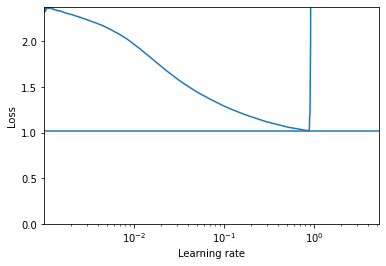

In [73]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.xlabel("Learning rate")
plt.ylabel("Loss")

#### Now we get a sense about what learning rate is acceptable

In [74]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [75]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=2e-1),
              metrics=["accuracy"])

In [76]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_mnist_model.h5", save_best_only=True)

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb, checkpoint_cb])

Epoch 1/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2326 - accuracy: 0.9287 - val_loss: 0.1004 - val_accuracy: 0.9704
Epoch 2/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0942 - accuracy: 0.9705 - val_loss: 0.0921 - val_accuracy: 0.9726
Epoch 3/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0615 - accuracy: 0.9806 - val_loss: 0.0746 - val_accuracy: 0.9806
Epoch 4/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0446 - accuracy: 0.9850 - val_loss: 0.0773 - val_accuracy: 0.9770
Epoch 5/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0362 - accuracy: 0.9884 - val_loss: 0.0681 - val_accuracy: 0.9798
Epoch 6/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0242 - accuracy: 0.9920 - val_loss: 0.0753 - val_accuracy: 0.9806
Epoch 7/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0189 - accuracy: 0.9938 - val_loss: 0.0735 - val_ac